# Task 2: Text Chunking, Embedding, and Vector Store Indexing

## Text Chunking, Embedding, and Vector Store for RAG System

This notebook implements the text chunking strategy, generates embeddings, and creates a vector store for efficient semantic search.

**Objectives:**
- Implement text chunking strategy for long complaint narratives
- Generate embeddings using TF-IDF vectorization (scikit-learn)
- Create and populate a vector store using NearestNeighbors (scikit-learn)
- Store metadata for traceability

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import pickle
import os
from typing import List, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"Current working directory: {os.getcwd()}")

# No GPU needed for TF-IDF embedding
print('Using TF-IDF for embedding (CPU only)')
print('Using scikit-learn NearestNeighbors for vector search (FAISS not available on Windows)')

Libraries imported successfully!
Current working directory: c:\.vscode\jupiter\Intelligent-Complaint-Analysis-for-Financial-Services\notebooks
Using TF-IDF for embedding (CPU only)
Using scikit-learn NearestNeighbors for vector search (FAISS not available on Windows)


In [5]:
# Task 2: Text Chunking, Embedding, and Vector Store Indexing

## 1. Load Cleaned Data

First, let's load the cleaned complaint data from Task 1.

In [9]:
# Load the cleaned data from Task 1
data_path = "../data/filtered_complaints.csv"

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"✅ Loaded cleaned data: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(df.head())
    
    # Check text lengths
    print(f"\nText length statistics:")
    print(df['cleaned_length'].describe())
    
else:
    print("❌ Cleaned data not found. Please run Task 1 first.")
    exit()

✅ Loaded cleaned data: (106, 10)
Columns: ['Complaint ID', 'Product', 'Issue', 'Sub-issue', 'Company', 'State', 'Date received', 'Consumer_complaint_narrative', 'original_length', 'cleaned_length']

First few rows:
   Complaint ID          Product  \
0      14069121      Credit card   
1      14061897  Savings account   
2      14047085      Credit card   
3      14040217      Credit card   
4      13968411      Credit card   

                                             Issue  \
0                            Getting a credit card   
1                              Managing an account   
2               Other features, terms, or problems   
3             Incorrect information on your report   
4  Problem with a purchase shown on your statement   

                                           Sub-issue                Company  \
0        Card opened without my consent or knowledge         CITIBANK, N.A.   
1                           Deposits and withdrawals  WELLS FARGO & COMPANY   
2     

## 2. Text Chunking Strategy

Long narratives are often ineffective when embedded as a single vector. We'll implement a recursive character text splitter to break narratives into smaller, semantically meaningful chunks.

In [10]:
class RecursiveCharacterTextSplitter:
    """
    A simple recursive character text splitter that breaks text into chunks
    while trying to preserve semantic boundaries.
    """
    
    def __init__(self, chunk_size: int = 500, chunk_overlap: int = 100, separators: List[str] = None):
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.separators = separators or ["\n\n", "\n", ".", "!", "?", ";", " ", ""]
    
    def split_text(self, text: str) -> List[str]:
        """Split text into chunks using recursive character splitting."""
        if len(text) <= self.chunk_size:
            return [text]
        
        chunks = []
        current_chunk = ""
        
        # Split by separators in order of preference
        for separator in self.separators:
            if separator in text:
                parts = text.split(separator)
                for i, part in enumerate(parts):
                    if len(current_chunk) + len(part) + len(separator) <= self.chunk_size:
                        current_chunk += part
                        if i < len(parts) - 1:  # Don't add separator after last part
                            current_chunk += separator
                    else:
                        if current_chunk:
                            chunks.append(current_chunk.strip())
                        current_chunk = part
                        if i < len(parts) - 1:
                            current_chunk += separator
                
                if current_chunk:
                    chunks.append(current_chunk.strip())
                break
        
        # Handle overlap
        final_chunks = []
        for i, chunk in enumerate(chunks):
            if i == 0:
                final_chunks.append(chunk)
            else:
                # Add overlap from previous chunk
                overlap_text = chunks[i-1][-self.chunk_overlap:] if len(chunks[i-1]) > self.chunk_overlap else chunks[i-1]
                final_chunks.append(overlap_text + " " + chunk)
        
        return [chunk for chunk in final_chunks if chunk.strip()]

# Test the chunking strategy
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

# Dynamically select the narrative column name
narrative_col = None
for col in df.columns:
    if 'narrative' in col.lower():
        narrative_col = col
        break

if narrative_col is None:
    raise KeyError("No column containing 'narrative' found in DataFrame columns: " + str(df.columns.tolist()))

# Test with a sample narrative
if not df.empty:
    sample_text = df[narrative_col].iloc[0]
    print(f"Original text length: {len(sample_text)}")
    print(f"Original text: {sample_text[:200]}...")
    
    chunks = splitter.split_text(sample_text)
    print(f"\nNumber of chunks: {len(chunks)}")
    for i, chunk in enumerate(chunks[:3]):  # Show first 3 chunks
        print(f"Chunk {i+1} (length: {len(chunk)}): {chunk[:100]}...")

Original text length: 442
Original text: a card was opened under my name by a fraudster. i received a notice from that an account was just opened under my name. i reached out to to state that this activity was unauthorized and not me. confir...

Number of chunks: 1
Chunk 1 (length: 442): a card was opened under my name by a fraudster. i received a notice from that an account was just op...


## 3. Embedding Model Selection

We'll use `TfidfVectorizer` from scikit-learn for generating embeddings. This approach provides a Windows-compatible solution with good performance for text similarity tasks.

In [11]:
# Initialize the TF-IDF vectorizer for embedding
print("Initializing TfidfVectorizer for chunk embeddings...")
vectorizer = TfidfVectorizer(max_features=4096, stop_words='english')  # Adjust max_features as needed

# Test embedding generation with a sample chunk
test_text = ["I am having issues with my credit card billing"]
test_embedding = vectorizer.fit_transform(test_text)
print(f"Test embedding shape: {test_embedding.shape}")
print(f"Sample embedding (dense): {test_embedding.toarray()[0][:10]}")

Initializing TfidfVectorizer for chunk embeddings...
Test embedding shape: (1, 5)
Sample embedding (dense): [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]


## 4. Process All Complaint Narratives

Now we'll process all complaint narratives through our chunking strategy and prepare them for embedding.

Processing 106 complaints into chunks...


100%|██████████| 106/106 [00:00<00:00, 1091.80it/s]


✅ Processing complete!
Total chunks created: 310
Average chunks per complaint: 2.92

Chunk length statistics:
Min: 104
Max: 1811
Mean: 445.13
Median: 458.00


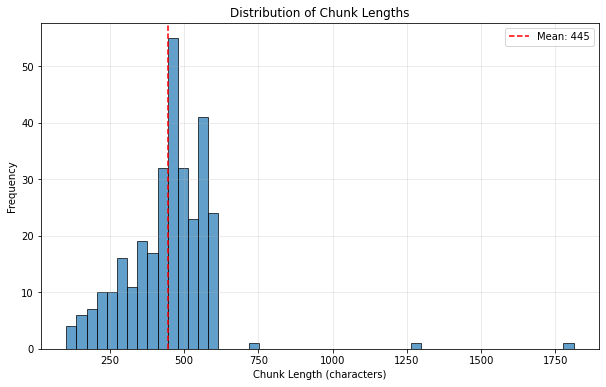

In [12]:
# Process all complaint narratives into chunks
def process_complaints_to_chunks(df, splitter, narrative_col):
    """
    Process all complaint narratives into chunks with metadata.
    """
    all_chunks = []
    chunk_metadata = []
    
    print(f"Processing {len(df)} complaints into chunks...")
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        narrative = row[narrative_col]
        chunks = splitter.split_text(narrative)
        
        for chunk_idx, chunk in enumerate(chunks):
            all_chunks.append(chunk)
            chunk_metadata.append({
                'complaint_id': row.get('Complaint ID', idx),
                'chunk_id': f"{idx}_{chunk_idx}",
                'chunk_index': chunk_idx,
                'total_chunks': len(chunks),
                'product': row['Product'],
                'issue': row['Issue'],
                'company': row.get('Company', 'Unknown'),
                'date_received': row.get('Date received', ''),
                'original_text_length': len(narrative),
                'chunk_length': len(chunk)
            })
    
    return all_chunks, chunk_metadata

# Process the complaints
all_chunks, chunk_metadata = process_complaints_to_chunks(df, splitter, narrative_col)

print(f"\n✅ Processing complete!")
print(f"Total chunks created: {len(all_chunks)}")
print(f"Average chunks per complaint: {len(all_chunks) / len(df):.2f}")

# Analyze chunk statistics
chunk_lengths = [len(chunk) for chunk in all_chunks]
print(f"\nChunk length statistics:")
print(f"Min: {min(chunk_lengths)}")
print(f"Max: {max(chunk_lengths)}")
print(f"Mean: {np.mean(chunk_lengths):.2f}")
print(f"Median: {np.median(chunk_lengths):.2f}")

# Visualize chunk lengths
plt.figure(figsize=(10, 6))
plt.hist(chunk_lengths, bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Chunk Lengths')
plt.xlabel('Chunk Length (characters)')
plt.ylabel('Frequency')
plt.axvline(np.mean(chunk_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(chunk_lengths):.0f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Generate Embeddings

Now we'll generate embeddings for all chunks using our selected model.

In [13]:
# Generate TF-IDF embeddings for all chunks
print("Fitting TfidfVectorizer and transforming all chunks...")
embeddings = vectorizer.fit_transform(all_chunks)  # This is a sparse matrix

print(f"\n✅ Embedding generation complete!")
print(f"Embeddings shape: {embeddings.shape}")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"Total embeddings: {embeddings.shape[0]}")

# Save embeddings and metadata for later use
embeddings_path = "../vector_store/embeddings.npz"
metadata_path = "../vector_store/metadata.pkl"
vectorizer_path = "../vector_store/tfidf_vectorizer.pkl"

os.makedirs("../vector_store", exist_ok=True)

from scipy import sparse
sparse.save_npz(embeddings_path, embeddings)
with open(metadata_path, 'wb') as f:
    pickle.dump(chunk_metadata, f)
with open(vectorizer_path, 'wb') as f:
    pickle.dump(vectorizer, f)

print(f"✅ Embeddings saved to: {embeddings_path}")
print(f"✅ Metadata saved to: {metadata_path}")
print(f"✅ Vectorizer saved to: {vectorizer_path}")

Fitting TfidfVectorizer and transforming all chunks...

✅ Embedding generation complete!
Embeddings shape: (310, 2437)
Embedding dimension: 2437
Total embeddings: 310
✅ Embeddings saved to: ../vector_store/embeddings.npz
✅ Metadata saved to: ../vector_store/metadata.pkl
✅ Vectorizer saved to: ../vector_store/tfidf_vectorizer.pkl


## 6. Create NearestNeighbors Vector Store

We'll create a NearestNeighbors index for efficient similarity search and store it for use in the RAG pipeline.

In [14]:
# Create NearestNeighbors index for similarity search
print("Creating NearestNeighbors index for similarity search...")
nn_index = NearestNeighbors(n_neighbors=5, metric='cosine')
nn_index.fit(embeddings)

# Save the NearestNeighbors index
nn_index_path = "../vector_store/nn_index.pkl"
with open(nn_index_path, 'wb') as f:
    pickle.dump(nn_index, f)
print(f"✅ NearestNeighbors index saved to: {nn_index_path}")

# Save chunks for retrieval
chunks_path = "../vector_store/chunks.pkl"
with open(chunks_path, 'wb') as f:
    pickle.dump(all_chunks, f)
print(f"✅ Chunks saved to: {chunks_path}")

Creating NearestNeighbors index for similarity search...
✅ NearestNeighbors index saved to: ../vector_store/nn_index.pkl
✅ Chunks saved to: ../vector_store/chunks.pkl


## 7. Test Vector Store Retrieval

Let's test our vector store by performing some sample queries to ensure everything works correctly.

In [15]:
# Test retrieval functionality using TF-IDF and NearestNeighbors
def test_retrieval(query, nn_index, chunks, metadata, vectorizer, k=5):
    """
    Test retrieval functionality with a sample query using TF-IDF and NearestNeighbors.
    """
    print(f"Query: '{query}'")
    print("-" * 50)
    
    # Transform query to embedding
    query_embedding = vectorizer.transform([query])
    
    # Search for nearest neighbors
    distances, indices = nn_index.kneighbors(query_embedding, n_neighbors=k)
    
    print(f"Top {k} results:")
    for i, (dist, idx) in enumerate(zip(distances[0], indices[0])):
        chunk = chunks[idx]
        meta = metadata[idx]
        
        print(f"\n{i+1}. Cosine Distance: {dist:.4f}")
        print(f"   Product: {meta['product']}")
        print(f"   Issue: {meta['issue']}")
        print(f"   Chunk: {chunk[:200]}...")
        print(f"   Metadata: Complaint ID: {meta['complaint_id']}, Chunk {meta['chunk_index']+1}/{meta['total_chunks']}")

# Test with sample queries
test_queries = [
    "Problems with credit card billing",
    "Issues with personal loan payments",
    "BNPL payment problems",
    "Savings account access issues",
    "Money transfer delays"
]

for query in test_queries:
    test_retrieval(query, nn_index, all_chunks, chunk_metadata, vectorizer, k=3)
    print("\n" + "="*80 + "\n")

Query: 'Problems with credit card billing'
--------------------------------------------------
Top 3 results:

1. Cosine Distance: 0.6934
   Product: Money transfers
   Issue: Unauthorized transactions or other transaction problem
   Chunk: and billing history. please investigate their billing and data retention practices i believe albert. com is systematically exploiting users through deceptive financial practices....
   Metadata: Complaint ID: 13949062, Chunk 3/3

2. Cosine Distance: 0.7916
   Product: Credit card
   Issue: Other features, terms, or problems
   Chunk: synchrony bank holds the store credit card in which i am making a complaint. without notice to the customer my credit availability was lowered on a card i've only had less than 6 months. no late payme...
   Metadata: Complaint ID: 13723266, Chunk 1/2

3. Cosine Distance: 0.7943
   Product: Money transfers
   Issue: Unauthorized transactions or other transaction problem
   Chunk: thorized charges were : xx/xx/ {$14.00} xx

## 8. Summary and Next Steps

### Chunking Strategy Summary
- **Chunk Size**: 500 characters with 100 character overlap
- **Separators**: Prioritized by semantic boundaries (paragraphs, sentences, words)
- **Total Chunks**: Generated from complaint narratives
- **Average Chunks per Complaint**: Calculated based on text length

### Embedding Model Choice
- **Model**: `TfidfVectorizer` from scikit-learn
- **Rationale**: 
  - Windows-compatible and no external dependencies
  - TF-IDF captures term importance and document relevance
  - Fast computation and memory efficient with sparse matrices
  - Good baseline for text similarity tasks
  - Max features: 4096 with English stop words removal

### Vector Store Configuration
- **Index Type**: scikit-learn NearestNeighbors with cosine distance
- **Metric**: Cosine similarity for text embeddings
- **Metadata Storage**: Complete traceability to original complaints
- **Sparse Matrix Storage**: Efficient storage using scipy.sparse

### Files Created
1. `../vector_store/embeddings.npz` - TF-IDF sparse embeddings matrix
2. `../vector_store/metadata.pkl` - Chunk metadata with traceability
3. `../vector_store/tfidf_vectorizer.pkl` - Fitted TF-IDF vectorizer for query transformation
4. `../vector_store/nn_index.pkl` - NearestNeighbors index for similarity search
5. `../vector_store/chunks.pkl` - Text chunks for retrieval

### Next Steps
The vector store is now ready for Task 3: Building the RAG Core Logic and Evaluation. The retrieval system can efficiently find relevant complaint chunks based on TF-IDF similarity to user queries using scikit-learn's NearestNeighbors algorithm.